In [1]:
import numpy as np
import h5py
from sklearn.metrics import roc_auc_score
import matplotlib.pyplot as plt
import time
from random import shuffle
from itertools import product
import multiprocessing as mp
from math import fabs,sqrt,log,exp

In [2]:
def bound(loss,L,lam):
    '''
    Calculate annoying parameters to estimate rho
    '''
        
    R1 = 0.0
    R2 = 0.0
    Sp1 = 0.0
    Sm1 = 0.0
    Sp2 = 0.0
    Sm2 = 0.0

    for i in range(N+1):
        # compute plus
        alpha0 = L**i
        alpha1 = i*L**(i-1)
        alpha2 = i*(i-1)*L**(i-2)
        R1 += alpha0
        Sp1 += alpha1
        Sp2 += alpha2
        # compute minus
        beta0 = 0.0
        beta1 = 0.0
        beta2 = 0.0
        for k in range(i,N+1):
            # compute forward difference
            delta = 0.0
            for j in range(k+1):
                delta += comb_dict[k][j]*(-1)**(k-j)*loss(j/N)
            # compute coefficient
            beta0 += comb_dict[N][k]*comb_dict[k][i]*(N+1)*fabs(delta)/(2**k)/(L**i)
            beta1 += comb_dict[N][k]*comb_dict[k][i]*(N+1)*(k-i)*fabs(delta)/(2**k)/(L**(i+1))
            beta2 += comb_dict[N][k]*comb_dict[k][i]*(N+1)*(k-i)*(k-i-1)*fabs(delta)/(2**k)/(L**(i+2))
        R2 += beta0
        Sm1 += beta1
        Sm2 += beta2
        
    gammap0 = max(Sp1+(2*R1+R2)*Sp2,1+Sp1)
    gammam0 = max(Sm1+(2*R2+R1)*Sm2,1+Sm1)
    gamma0_v1 = sqrt(3)/(N+1)*max(gammap0,gammam0)
    
    rho = max((2*R1+R2)*Sp2/(N+1),(2*R2+R1)*Sm2/(N+1))
    gamma0_v2 = max(0,(fabs(1+(rho-lam)*(N+1))-1)/2/(N+1)+(rho-lam)/2)
    print('R1: %.2f, R2: %.2f gamma: %.2f' %(R1,R2,gamma0_v2))
    return R1,R2,rho,gamma0_v1,gamma0_v2

In [36]:
def loss_func(loss,lam):
    
    # define loss function
    if loss == 'hinge':
        L = 2*sqrt(2/lam)
        l = lambda x: max(0,1+L-2*L*x)
    elif loss == 'logistic':
        L = 2*sqrt(2*log(2)/lam)
        l = lambda x:log(1+exp(L-2*L*x))
    else:
        print('Wrong loss function!')
        return
    
    print('L: %f'%L)
    
    return l,L

In [149]:
lo,L = loss_func(loss,1)
bound(lo,L,1)

L: 2.828427
R1: 279.48, R2: 51.74 gamma: 57762.02


(279.47518010647195,
 51.73959660144271,
 57763.0156976693,
 100175.8317919486,
 57762.0156976693)

In [4]:
def right_func(L,lam):
    return lam/2*(L/2)**2

In [5]:
def left_func(loss,L):
    
    if loss == 'hinge':
        l = lambda x: max(0,1+L-2*L*x)
    elif loss == 'logistic':
        l = lambda x:log(1+exp(L-2*L*x))
    else:
        print('Wrong loss function!')
    
    B0 = 0.0
    for k in range(N+1):
        B0 += comb_dict[N][k]*l(k/N)
        
    return B0/2**N

In [6]:
def dichotomy(loss,lam,a,b,tol,max_iter):
    fa = right_func(a,lam) - left_func(loss,a)
    fb = right_func(b,lam) - left_func(loss,b)
    if fa*fb > 0:
        print('Wrong search!')
        return
    i = 1
    while i<max_iter:
        fa = right_func(a,lam) - left_func(loss,a)
        fb = right_func(b,lam) - left_func(loss,b)
        c = (a+b)/2
        fc = right_func(c,lam) - left_func(loss,c)
        if fc == 0 or (b - a)/2 < tol:
            print('Found!')
            return c
        i += 1
        if fa*fc > 0:
            a = c+0.0
        else:
            b = c+0.0
    print('Failed!')
    return

In [7]:
def pos(i,prod,L):
    '''
    Compute positive function and gradient information
    
    input:
        i - index of function
        t - iteration
        prod - wt*xt
        
    output:
        fpt - positive function value
        gfpt - positive function gradient
    '''
    plus = L/2+prod
    fpt = plus**i
    gfpt = fpt*i/plus # no xt yet!
    return fpt,gfpt              

In [8]:
def comb(n, k):
    '''
    Compute combination
    
    input:
        n - total number
        k - number of chosen
    
    output:
        c - number of combination
    '''
    return factorial(n) / factorial(k) / factorial(n - k)

In [9]:
comb_dict = {0:{0:1},1:{0:1,1:1},2:{0:1,1:2,2:1},3:{0:1,1:3,2:3,3:1},4:{0:1,1:4,2:6,3:4,4:1},
             5:{0:1,1:5,2:10,3:10,4:5,5:1},6:{0:1,1:6,2:15,3:20,4:15,5:6,6:1},
             7:{0:1,1:7,2:21,3:35,4:35,5:21,6:7,7:1},8:{0:1,1:8,2:28,3:56,4:70,5:56,6:28,7:8,8:1},
             9:{0:1,1:9,2:36,3:84,4:126,5:126,6:84,7:36,8:9,9:1},
             10:{0:1,1:10,2:45,3:120,4:210,5:252,6:210,7:120,8:45,9:10,10:1}}

In [10]:
def neg(loss,i,prod,L):
    '''
    Compute negative function and gradient information
    
    input:
        loss - loss function
        i - index of function
        t - iteration
        prod - wt*xt
        
    output:
        fnt - negative function value
        gfnt - negative function gradient
    '''
    minus = L/2-prod
    #FNT = np.zeros(N+1-i)
    #GFNT = np.zeros(N+1-i)
    fnt = 0.0
    gfnt = 0.0
    # hfnt = 0.0
    for k in range(i,N+1):
        # compute forward difference
        delta = 0.0
        for j in range(k+1):
            delta += comb_dict[k][j]*(-1)**(k-j)*loss(j/N)
            
        # compute coefficient
        #beta = beta_dict[i][k-i]*delta/(2*L)**k*minus**(k-i)
        beta = (comb_dict[N][k]*comb_dict[k][i]*(N+1)*delta/((2*L)**k))*(minus**(k-i))
        # compute function value
        fnt += beta
        # compute gradient
        gfnt += beta*(k-i)/minus  # no xt yet!
        
        # compute hessian
        # hfnt += beta*(k-i)*(k-i-1)*(L/2-prod)**(k-i-2)
    return fnt,gfnt

In [11]:
def w_grad(gfpt,gfnt,yt,at,bt,alphat):
    '''
    Gradient with respect to w
    
    input:
        fpt - positive function at t
        gfpt - positive function gradient at t
        fnt - negative function at t
        gfnt - negative function gradient at t
        yt - sample label at t
        pt - p at t
        at - a at t
        bt - b at t
        alphat - alpha at t
    output:
        gradwt - gradient w.r.t. w at t
    '''
    if yt == 1:
        gradwt = 2*(alphat - at)*gfpt
    else:
        gradwt = 2*(alphat - bt)*gfnt
    return gradwt

In [12]:
def proj(wt,R):
    '''
    Projection
    
    input:
        wt - w at t
        R - radius
        
    output:
        proj - projected wt
    '''
    norm = np.linalg.norm(wt)
    if norm > R:
        wt = wt/norm*R
    return wt

In [13]:
def a_grad(fpt,yt,at):
    '''
    Gradient with respect to a
    
    input:
        fpt - positive function at t
        yt - sample label at t
        pt - p at t
        at - a at t
    
    output:
        gradat - gradient w.r.t a at t
    '''
    gradat = 0.0 
    if yt == 1:
        gradat = 2*(at - fpt)
    else:
        gradat = 2*at
    return gradat

In [14]:
def b_grad(fnt,yt,bt):
    '''
    Gradient with respect to b
    
    input:
        fnt - negative function at t
        yt - sample label at t
        pt - p at t
        bt - b at t
    
    output:
        gradbt - gradient w.r.t b at t
    '''
    gradbt = 0.0 
    if yt == 1:
        gradbt = 2*bt
    else:
        gradbt = 2*(bt - fnt)
    return gradbt

In [15]:
def alpha_grad(fpt,fnt,yt,alphat):
    '''
    Gradient with respect to alpha
    '''
    gradalphat = 0.0
    if yt == 1:
        gradalphat = -2*(alphat - fpt)
    else:
        gradalphat = -2*(alphat - fnt)
    return gradalphat

In [103]:
def split(folder,folders):
    
    if folder >= folders:
        print('Exceed maximum folders!')
        return
    # load and split data
    n,d = FEATURES.shape
    
    # regular portion of each folder
    portion = round(n/folders)
    start = portion*folder
    stop = portion*(folder+1)
    
    if folders == 1:
        train_list = [i for i in range(n)]
        test_list = [i for i in range(n)]
        
    elif folders == 2:
        if folder == 0:
            train_list = [i for i in range(start)] + [i for i in range(stop,n)]
            test_list = [i for i in range(start,stop)]
        else:
            train_list = [i for i in range(start)]
            test_list = [i for i in range(start,n)]
            
    else:
        if fabs(stop - n) < portion: # remainder occurs
            train_list = [i for i in range(start)]
            test_list = [i for i in range(start,n)]
        else:
            train_list = [i for i in range(start)] + [i for i in range(stop,n)]
            test_list = [i for i in range(start,stop)]
        
    return train_list,test_list

In [133]:
def prox(eta,loss,index,L,R1,R2,gamma,lam,wj,aj,bj,alphaj,bwt,bat,bbt,balphat):
    '''
    perform proximal guided gradient descent when receive an sample
    '''
    prod = np.dot(wj,FEATURES[index])
    fpt = np.zeros(N+1)
    gfpt = np.zeros(N+1)
    fnt = np.zeros(N+1)
    gfnt = np.zeros(N+1)
    gradwt = 0.0
    gradat = 0.0
    gradbt = 0.0
    gradalphat = 0.0
    for i in range(N+1):
        fpt[i],gfpt[i] = pos(i,prod,L)
        fnt[i],gfnt[i] = neg(loss,i,prod,L)
        gradwt += w_grad(gfpt[i],gfnt[i],LABELS[index],aj[i],bj[i],alphaj[i])# accumulate i
        gradat = a_grad(fpt[i],LABELS[index],aj[i])
        gradbt = b_grad(fnt[i],LABELS[index],bj[i])
        gradalphat = alpha_grad(fpt[i],fnt[i],LABELS[index],alphaj[i])
        aj[i] = aj[i] - eta*(gradat/(2*(N+1))+gamma*(aj[i]-bat[i]))
        bj[i] = bj[i] - eta*(gradbt/(2*(N+1))+gamma*(bj[i]-bbt[i]))
        #aj[i] = (aj[i] / eta + gamma * bat[i] - gradat/(2*(N+1))) / (1 / eta + gamma)
        #bj[i] = (bj[i] / eta + gamma * bbt[i] - gradbt/(2*(N+1))) / (1 / eta + gamma)
        alphaj[i] = alphaj[i] + eta*gradalphat/(2*(N+1))
        #alphaj[i] = (alphaj[i]/eta + (gradalphat+alphaj[i])/(2*(N+1))) / (1 / eta + gamma)
    
    wj = wj - eta*(gradwt*FEATURES[index]*LABELS[index]/(2*(N+1)) + lam*wj + gamma*(wj - bwt))
    #wj = (wj/eta+gamma*bwt-gradwt*FEATURES[index]*LABELS[index]/(2*(N+1)))/(1 / eta + gamma+ lam)
    wj = proj(wj,L/2)
    aj = proj(aj,R1)
    bj = proj(bj,R2)
    alphaj = proj(alphaj,R1+R2)
    
    return wj,aj,bj,alphaj

In [18]:
def PGSPD(t,loss,passing_list,L,R1,R2,gamma,lam,theta,c,bwt,bat,bbt,balphat):
    '''
    Proximally Guided Stochastic Primal Dual Algorithm
    '''
    # initialize inner loop variables
    Wt = bwt+0.0
    At = bat+0.0
    Bt = bbt+0.0
    ALPHAt = balphat+0.0
    
    BWt = 0.0
    BAt = 0.0
    BBt = 0.0
    BALPHAt = 0.0
    
    ETAt = c/(t**theta)/gamma
    
    # inner loop update at j
    for j in range(t):
        # update inner loop variables
        Wt,At,Bt,ALPHAt = prox(ETAt,loss,passing_list[j],L,R1,R2,gamma,lam,Wt,At,Bt,ALPHAt,bwt,bat,bbt,balphat)
        BWt += Wt
        BAt += At
        BBt += Bt
        BALPHAt += ALPHAt
        
    # update outer loop variables
    bwt = BWt/t
    bat = BAt/t
    bbt = BBt/t
    balphat = BALPHAt/t
    
    return bwt,bat,bbt,balphat

In [45]:
def demo(loss,train_list,test_list,L,R1,R2,gamma=0.01,lam=10,theta=0.5,c = 1):
    '''
    Run it to get results
    '''
    
    # get dimensions of the data
    num = len(train_list)
    _,d = FEATURES.shape
    
    # initialize outer loop variables
    WT = np.zeros(d) # d is the dimension of the features
    AT = np.zeros(N+1)
    BT = np.zeros(N+1)
    ALPHAT = np.zeros(N+1)


    # record auc
    roc_auc = np.zeros(T)
    # record time elapsed
    start_time = time.time()
    
    for t in range(1,T+1):    
        
        epoch = t // num
        begin = (t*(t-1)//2)%num
        end = (t*(t+1)//2)%num

        if epoch < 1:
            if begin < end:
                tr_list = [i for i in range(begin,end)]
            else: # need to think better
                tr_list = [i for i in range(begin,num)] + [i for i in range(end)]
        else:
            if begin < end:
                tr_list = [i for i in range(begin,num)] + [i for i in range(num)]*(epoch-1) + [i for i in range(end)]
            else:
                tr_list = [i for i in range(begin,num)] + [i for i in range(num)]*epoch + [i for i in range(end)]
                
        shuffle(tr_list) # shuffle works in place
        
        # update outer loop variables
        WT,AT,BT,ALPHAT = PGSPD(t,loss,tr_list,L,R1,R2,gamma,lam,theta,c,WT,AT,BT,ALPHAT)   
        
        try:
            roc_auc[t-1] = roc_auc_score(LABELS[test_list], np.dot(FEATURES[test_list],WT))
        except ValueError:
            print('Something is wrong bruh! Look at sum of WT: %f' %(sum(WT)))
            return WT,AT,BT,ALPHAT,roc_auc
        
        if t%100 == 0:
            elapsed_time = time.time() - start_time
            print('gamma: %.2f lam: %.2f theta: %.2f c: %.2f iteration: %d AUC: %.6f time eplapsed: %.2f' 
                  %(gamma,lam,theta,c,t,roc_auc[t-1],elapsed_time))
            start_time = time.time()
            
    return WT,AT,BT,ALPHAT,roc_auc

In [47]:
def single_run(para):
    
    folder,gamma,lam,theta,c,paras = para
    training,testing,loss = paras
    
    # define loss function
    lo,L = loss_func(loss,LAM[lam])
    
    # compute bound for a,b and alpha
    R1,R2,_,_,_ = bound(lo,L,LAM[lam]) 
    
    _,_,_,_,roc_auc = demo(lo,training,testing,L,R1,R2,gamma=GAMMA[gamma],lam=LAM[lam],theta=THETA[theta],c=C[c])
    
    return folder,gamma,lam,theta,c, roc_auc

In [51]:
def gs(loss,folders=5,GAMMA=[0.01],LAM=[10.0],THETA=[0.25],C=[10.0]):
    '''
    Grid search! Wuss up fellas?!
    And we are using multiprocessing, fancy!
    '''
    # number of cpu want to use
    num_cpus = 15
    # record auc
    ROC_AUC = np.zeros((folders,len(GAMMA),len(LAM),len(THETA),len(C),T))
    # record parameters
    input_paras = []
    # grid search prepare
    for folder in range(folders):
        training,testing = split(folder,folders)
        paras = training,testing,loss
        for gamma,lam,theta,c in product(range(len(GAMMA)),range(len(LAM)),range(len(THETA)),range(len(C))):
            input_paras.append((folder,gamma,lam,theta,c,paras))
    print('dataset: %s how many paras: %d' % (dataset,len(input_paras)))
    # grid search run on multiprocessors
    with mp.Pool(processes=num_cpus) as pool:
        results_pool = pool.map(single_run,input_paras)
        pool.close()
        pool.join()
    # save results
    for folder,gamma,lam,theta,c, roc_auc in results_pool:
        ROC_AUC[folder,gamma,lam,theta,c] = roc_auc
    return ROC_AUC

In [23]:
def compute(x):
    folders,GAMMA,LAM,THETA,C = x.shape

    MEAN = np.zeros((GAMMA, LAM, THETA, C))
    STD = np.zeros((GAMMA, LAM, THETA, C))

    for gamma, lam, theta, c in product(range(GAMMA), range(LAM), range(THETA), range(C)):
        MEAN[gamma, lam, theta, c] = np.mean(x[:, gamma, lam, theta, c])
        STD[gamma, lam, theta, c] = np.std(x[:, gamma, lam, theta, c])

    return MEAN,STD

In [40]:
def smooth(loss,gamma=1,lam=10,theta=0.5,c = 1):
    '''
    Smooth output auc by averaging
    '''
    
    num = len(LABELS)
    training = [i for i in range(num)]
    testing = [i for i in range(num)]
    
    # define loss function
    lo,L = loss_func(loss,lam)
    
    # compute bound for a,b and alpha
    R1,R2,_,_,_ = bound(lo,L,lam) 
    
    _,_,_,_,roc_auc = demo(lo,training,testing,L,R1,R2,gamma=gamma,lam=lam,theta=theta,c=c)
    
    return roc_auc

In [137]:
def draw(ROC_AUC):
    '''
    Plot AUC
    '''
    for gamma,lam,theta,c in product(range(len(GAMMA)),range(len(LAM)),range(len(THETA)),range(len(C))):
        plt.plot(range(T),ROC_AUC[0,gamma,lam,theta,c],label=r'$\gamma$ = %d'%GAMMA[gamma])
    plt.xlabel('iterations')
    plt.ylabel('AUC')
    plt.legend()
    
    return 

In [116]:
# Read data from hdf5 file
i = 1
dataset = 'german'
hf = h5py.File('%s.h5' %(dataset), 'r')
FEATURES = hf['FEATURES'][:]
LABELS = hf['LABELS'][:]
hf.close()

In [144]:
# Define hyper parameters
N=5
T=1000
folders=2

In [145]:
# Define model parameters
GAMMA = [10,100]
LAM = [10]
THETA = [0.5]
C = [1]

In [146]:
# Define hyper parameters
loss = 'hinge'

In [147]:
x = gs(loss,folders=folders,GAMMA=GAMMA,LAM=LAM,THETA=THETA,C=C)

dataset: german how many paras: 4
L: 0.894427
L: 0.894427
L: 0.894427
L: 0.894427
R1: 4.62, R2: 22.73 gamma: 156.70
R1: 4.62, R2: 22.73 gamma: 156.70
R1: 4.62, R2: 22.73 gamma: 156.70
R1: 4.62, R2: 22.73 gamma: 156.70
gamma: 100.00 lam: 10.00 theta: 0.50 c: 1.00 iteration: 100 AUC: 0.605637 time eplapsed: 5.30
gamma: 10.00 lam: 10.00 theta: 0.50 c: 1.00 iteration: 100 AUC: 0.595730 time eplapsed: 6.03
gamma: 100.00 lam: 10.00 theta: 0.50 c: 1.00 iteration: 100 AUC: 0.585145 time eplapsed: 6.86
gamma: 10.00 lam: 10.00 theta: 0.50 c: 1.00 iteration: 100 AUC: 0.619719 time eplapsed: 9.13
gamma: 100.00 lam: 10.00 theta: 0.50 c: 1.00 iteration: 200 AUC: 0.606562 time eplapsed: 15.85
gamma: 10.00 lam: 10.00 theta: 0.50 c: 1.00 iteration: 200 AUC: 0.638272 time eplapsed: 15.55
gamma: 100.00 lam: 10.00 theta: 0.50 c: 1.00 iteration: 200 AUC: 0.585448 time eplapsed: 15.25
gamma: 10.00 lam: 10.00 theta: 0.50 c: 1.00 iteration: 200 AUC: 0.659571 time eplapsed: 15.73
gamma: 100.00 lam: 10.00 theta

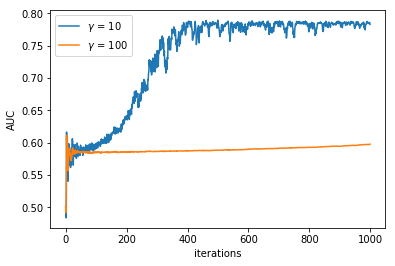

In [148]:
draw(x)